<a href="https://colab.research.google.com/github/busung/machine-learning-practice/blob/main/15%EB%B6%84%EA%B9%8C%EC%A7%80%EC%9D%98_%EC%8B%9C%EA%B3%84%EC%97%B4_%EC%9E%90%EB%A3%8C%EB%A5%BC_%EA%B0%80%EC%A7%80%EA%B3%A0_%EC%8A%B9%EB%B6%80%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM을 이용한 승부 예측

## 데이터 전처리

In [ ]:
from google.colab import drive
drive._mount('/content/gdriv')

Drive already mounted at /content/gdriv; to attempt to forcibly remount, call drive.mount("/content/gdriv", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data = pd.read_csv('/content/gdriv/MyDrive/소웨융/match_data.csv')

In [ ]:
data.head()

,match_id,player0_champion,player1_champion,player2_champion,player3_champion,player4_champion,player5_champion,player6_champion,player7_champion,player8_champion,player9_champion,player0_summoner_spell,player1_summoner_spell,player2_summoner_spell,player3_summoner_spell,player4_summoner_spell,player5_summoner_spell,player6_summoner_spell,player7_summoner_spell,player8_summoner_spell,player9_summoner_spell,player0_keystone,player1_keystone,player2_keystone,player3_keystone,player4_keystone,player5_keystone,player6_keystone,player7_keystone,player8_keystone,player9_keystone,blue_gold_5,red_gold_5,blue_kills_5,red_kills_5,blue_towers_5,red_towers_5,blue_dragons_5,red_dragons_5,blue_heralds_5,red_heralds_5,blue_gold_10,red_gold_10,blue_kills_10,red_kills_10,blue_towers_10,red_towers_10,blue_dragons_10,red_dragons_10,blue_heralds_10,red_heralds_10,blue_gold_15,red_gold_15,blue_kills_15,red_kills_15,blue_towers_15,red_towers_15,blue_dragons_15,red_dragons_15,blue_heralds_15,red_heralds_15,winner
0,NA1_4110079710,Kennen,Ekko,Yasuo,Draven,Alistar,Teemo,Hecarim,Leblanc,Xayah,Yuumi,Teleport,Smite,Ignite,Heal,Ignite,Ignite,Ghost,Teleport,Heal,Exhaust,Summon Aery,Electrocute,Lethal Tempo,Dark harvest,Glacial Augment,Summon Aery,Predator,Electrocute,Summon Aery,Summon Aery,5615,5872,0,0,0,0,0,0,0,0,14872,13502,5,2,0,0,0,0,0,0,23884,22389,7,4,1,0,1,0,0,1,Red
1,NA1_4139115929,Camille,Elise,Zed,Jhin,Taliyah,Shen,Shaco,Xerath,Brand,Senna,Teleport,Smite,Ignite,Heal,Ignite,Ignite,Smite,Exhaust,Heal,Barrier,Grasp of the Undying,Press the Attack,Electrocute,Fleet Footwork,Dark harvest,Grasp of the Undying,Hail of Blades,Arcane Comet,Arcane Comet,Summon Aery,6861,5584,3,0,0,0,0,0,0,0,17859,13110,12,3,0,0,0,0,0,0,27982,22045,19,7,1,0,1,0,1,0,Blue
2,NA1_4139129979,Karthus,Akshan,Zed,Jinx,Sona,Viktor,Kayn,Yasuo,MissFortune,Lux,Exhaust,Smite,Ignite,Heal,Ignite,Teleport,Smite,Ignite,Heal,Ignite,First Strike,Press the Attack,Electrocute,Lethal Tempo,Summon Aery,First Strike,First Strike,Lethal Tempo,Press the Attack,Arcane Comet,6284,7098,2,3,0,0,0,0,0,0,14563,16260,5,7,0,0,0,0,0,0,27073,28120,14,18,0,0,0,1,0,0,Blue
3,NA1_4139074211,Ornn,Kayn,Yasuo,Kaisa,Blitzcrank,Malphite,Graves,Lux,Ezreal,Sona,Teleport,Smite,Ignite,Heal,Exhaust,Teleport,Smite,Teleport,Exhaust,Heal,Grasp of the Undying,Dark harvest,Lethal Tempo,Hail of Blades,Glacial Augment,Arcane Comet,Fleet Footwork,Summon Aery,Conqueror,Summon Aery,5679,5457,0,0,0,0,0,0,0,0,13938,12464,3,2,0,0,0,0,0,0,23346,22890,6,8,0,0,1,0,0,1,Red
4,NA1_4138986434,Camille,Elise,Corki,Caitlyn,Karma,Fiora,LeeSin,Viktor,Jhin,Yuumi,Ignite,Smite,Teleport,Heal,Ignite,Teleport,Smite,Teleport,Heal,Exhaust,Grasp of the Undying,Dark harvest,First Strike,Lethal Tempo,Arcane Comet,Conqueror,Conqueror,First Strike,Dark harvest,Summon Aery,6499,5317,2,0,0,0,0,0,0,0,14667,12439,4,1,0,0,0,0,0,0,25358,19436,10,2,1,0,0,1,0,0,Blue


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 62 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   match_id                12000 non-null  object
 1   player0_champion        12000 non-null  object
 2   player1_champion        12000 non-null  object
 3   player2_champion        12000 non-null  object
 4   player3_champion        12000 non-null  object
 5   player4_champion        12000 non-null  object
 6   player5_champion        12000 non-null  object
 7   player6_champion        12000 non-null  object
 8   player7_champion        12000 non-null  object
 9   player8_champion        12000 non-null  object
 10  player9_champion        12000 non-null  object
 11  player0_summoner_spell  12000 non-null  object
 12  player1_summoner_spell  12000 non-null  object
 13  player2_summoner_spell  12000 non-null  object
 14  player3_summoner_spell  12000 non-null  object
 15  pl

In [ ]:
data_X = data.iloc[:,31:61]
data_Y = data.iloc[:,61]

In [ ]:
data_X.head()

,blue_gold_5,red_gold_5,blue_kills_5,red_kills_5,blue_towers_5,red_towers_5,blue_dragons_5,red_dragons_5,blue_heralds_5,red_heralds_5,blue_gold_10,red_gold_10,blue_kills_10,red_kills_10,blue_towers_10,red_towers_10,blue_dragons_10,red_dragons_10,blue_heralds_10,red_heralds_10,blue_gold_15,red_gold_15,blue_kills_15,red_kills_15,blue_towers_15,red_towers_15,blue_dragons_15,red_dragons_15,blue_heralds_15,red_heralds_15
0,5615,5872,0,0,0,0,0,0,0,0,14872,13502,5,2,0,0,0,0,0,0,23884,22389,7,4,1,0,1,0,0,1
1,6861,5584,3,0,0,0,0,0,0,0,17859,13110,12,3,0,0,0,0,0,0,27982,22045,19,7,1,0,1,0,1,0
2,6284,7098,2,3,0,0,0,0,0,0,14563,16260,5,7,0,0,0,0,0,0,27073,28120,14,18,0,0,0,1,0,0
3,5679,5457,0,0,0,0,0,0,0,0,13938,12464,3,2,0,0,0,0,0,0,23346,22890,6,8,0,0,1,0,0,1
4,6499,5317,2,0,0,0,0,0,0,0,14667,12439,4,1,0,0,0,0,0,0,25358,19436,10,2,1,0,0,1,0,0


In [ ]:
final_data = pd.DataFrame()

In [ ]:
for i in range(30):
  if i % 2 != 0:
    continue
  final_data[i] = data_X.iloc[:,i] - data_X.iloc[:,i+1]#blue-red

In [ ]:
final_data.head()

,0,2,4,6,8,10,12,14,16,18,20,22,24,26,28
0,-257,0,0,0,0,1370,3,0,0,0,1495,3,1,1,-1
1,1277,3,0,0,0,4749,9,0,0,0,5937,12,1,1,1
2,-814,-1,0,0,0,-1697,-2,0,0,0,-1047,-4,0,-1,0
3,222,0,0,0,0,1474,1,0,0,0,456,-2,0,1,-1
4,1182,2,0,0,0,2228,3,0,0,0,5922,8,1,-1,0


In [ ]:
final_data.columns = ['gold_5','kills_5','towes_5','dragons_5','heralds_5','gold_10','kills_10','towes_10','dragons_10','heralds_10','gold_15','kills_15','towes_15','dragons_15','heralds_15']

In [ ]:
final_data.head()

,gold_5,kills_5,towes_5,dragons_5,heralds_5,gold_10,kills_10,towes_10,dragons_10,heralds_10,gold_15,kills_15,towes_15,dragons_15,heralds_15
0,-257,0,0,0,0,1370,3,0,0,0,1495,3,1,1,-1
1,1277,3,0,0,0,4749,9,0,0,0,5937,12,1,1,1
2,-814,-1,0,0,0,-1697,-2,0,0,0,-1047,-4,0,-1,0
3,222,0,0,0,0,1474,1,0,0,0,456,-2,0,1,-1
4,1182,2,0,0,0,2228,3,0,0,0,5922,8,1,-1,0


In [ ]:
#Blue = 0 Red =1
Y = []
for i in data_Y:
  if i == 'Red':
    Y.append(1)
  else:
    Y.append(0)

In [ ]:
from tensorflow.keras.utils import to_categorical
X = final_data.to_numpy()
Y = to_categorical(Y)

## 데이터 분리

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
mms = MinMaxScaler()
mms.fit(X)
X_scaled = mms.transform(X)

In [ ]:
train_x,test_x,train_y,test_y = train_test_split(X,Y,test_size=0.2)

## 모델 생성

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Flatten
from tensorflow import keras

In [ ]:
model = keras.Sequential()
model.add(keras.layers.LSTM(128,input_shape=(15,1),return_sequences=True))#RNN 계열 신경망들은 반환 시 마지막 타임스텝의 값만 반환함, 하지만 층 끼리 연결시 모든 타임스텝의 값이 필요하기에 return_sequences=True를 지정
model.add(keras.layers.LSTM(64,return_sequences=True))
model.add(keras.layers.LSTM(32))
model.add(keras.layers.Dense(32,activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(16,activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(2,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 15, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('best_model.h5',save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

## 학습

In [ ]:
history=model.fit(train_x,train_y,epochs=100,batch_size=10,validation_data=(test_x,test_y),callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/100
960/960 [==============================] - 11s 8ms/step - loss: 0.5003 - accuracy: 0.7717 - val_loss: 0.4922 - val_accuracy: 0.7475
Epoch 2/100
960/960 [==============================] - 7s 7ms/step - loss: 0.4985 - accuracy: 0.7726 - val_loss: 0.4960 - val_accuracy: 0.7546
Epoch 3/100
960/960 [==============================] - 7s 7ms/step - loss: 0.4973 - accuracy: 0.7700 - val_loss: 0.4898 - val_accuracy: 0.7529
Epoch 4/100
960/960 [==============================] - 7s 8ms/step - loss: 0.4933 - accuracy: 0.7721 - val_loss: 0.4900 - val_accuracy: 0.7558
Epoch 5/100
960/960 [==============================] - 7s 8ms/step - loss: 0.4939 - accuracy: 0.7700 - val_loss: 0.4925 - val_accuracy: 0.7588
Epoch 6/100
960/960 [==============================] - 7s 8ms/step - loss: 0.4956 - accuracy: 0.7696 - val_loss: 0.4904 - val_accuracy: 0.7563
Epoch 7/100
960/960 [==============================] - 7s 8ms/step - loss: 0.4932 - accuracy: 0.7727 - val_loss: 0.4912 - val_accuracy: 0.750

## 평가

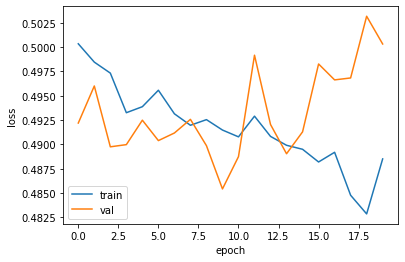

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
best_model = keras.models.load_model('best_model.h5')

In [ ]:
best_model.evaluate(test_x,test_y)

75/75 [==============================] - 1s 4ms/step - loss: 0.4743 - accuracy: 0.7721


[0.47432586550712585, 0.7720833420753479]

In [ ]:
final_data.head()

,gold_5,kills_5,towes_5,dragons_5,heralds_5,gold_10,kills_10,towes_10,dragons_10,heralds_10,gold_15,kills_15,towes_15,dragons_15,heralds_15
0,-257,0,0,0,0,1370,3,0,0,0,1495,3,1,1,-1
1,1277,3,0,0,0,4749,9,0,0,0,5937,12,1,1,1
2,-814,-1,0,0,0,-1697,-2,0,0,0,-1047,-4,0,-1,0
3,222,0,0,0,0,1474,1,0,0,0,456,-2,0,1,-1
4,1182,2,0,0,0,2228,3,0,0,0,5922,8,1,-1,0


In [ ]:
final_data[(final_data['gold_5']>0) & (final_data['gold_10']<0) & (final_data['gold_15']>0)]

,gold_5,kills_5,towes_5,dragons_5,heralds_5,gold_10,kills_10,towes_10,dragons_10,heralds_10,gold_15,kills_15,towes_15,dragons_15,heralds_15
13,425,1,0,0,0,-590,1,0,1,0,1366,7,0,2,-1
18,802,2,0,0,0,-534,2,0,0,0,1679,5,1,-1,1
43,338,1,0,0,0,-1247,-2,0,-1,0,859,0,1,-1,1
46,576,1,0,0,0,-239,0,0,1,0,378,1,0,1,1
89,695,1,0,0,0,-1096,-1,0,1,0,3118,4,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11956,477,1,0,0,0,-661,0,0,-1,0,1221,6,0,0,1
11971,91,0,0,0,0,-263,0,0,0,0,733,-1,1,-1,1
11974,522,0,0,0,0,-201,-2,0,-1,1,569,0,0,-2,1
11979,795,2,0,0,0,-620,-1,0,1,0,786,0,0,2,1


In [ ]:
test_0=final_data.iloc[0,].to_numpy().reshape(1,15)#지다가 역전
test_1=final_data.iloc[1,].to_numpy().reshape(1,15)#일방적일 때
test_2=final_data.iloc[43,].to_numpy().reshape(1,15)#지다가 역전의 역전

In [ ]:
test_0=mms.transform(test_0)
test_1=mms.transform(test_1)
test_2=mms.transform(test_2)

In [ ]:
a=np.argmax(best_model.predict(test_0))
b=np.argmax(best_model.predict(test_1))
c=np.argmax(best_model.predict(test_2))
print(a,b,c)

0 0 0


In [ ]:
print(Y[0],Y[1],Y[43])

[0. 1.] [1. 0.] [1. 0.]


In [ ]:
print(best_model.predict(test_0),best_model.predict(test_1),best_model.predict(test_2))

[[0.6727863 0.3280781]] [[0.72033143 0.2803253 ]] [[0.67406434 0.3268281 ]]


# XGBoost를 활용한 중요도 분석

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform,randint

## 데이터 전처리

In [ ]:
Y = []
for i in data_Y:
  if i == 'Red':
    Y.append(1)
  else:
    Y.append(0)

In [ ]:
X_15=X[:,10:15]

## 데이터 분리

In [ ]:
train_x,test_x,train_y,test_y = train_test_split(X_15,Y,test_size=0.2)

## 랜덤 서치를 활용한 하이퍼 파라미터 탐색

In [ ]:
xgb_model = XGBClassifier(n_estimators=100)

params = {'max_depth':randint(3,8), 'min_child_weight':randint(1,3), 'colsample_bytree':uniform(0.5,1)}

randcv = RandomizedSearchCV(xgb_model,params, n_iter=100)

randcv.fit(train_x, train_y, early_stopping_rounds=30, eval_metric='auc', eval_set=[(test_x, test_y)])

print(randcv.best_params_)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[37]	validation_0-auc:0.849747
[38]	validation_0-auc:0.849831
[39]	validation_0-auc:0.84985
[40]	validation_0-auc:0.849763
[41]	validation_0-auc:0.849793
[42]	validation_0-auc:0.849787
[43]	validation_0-auc:0.849738
[44]	validation_0-auc:0.849591
[45]	validation_0-auc:0.849555
[46]	validation_0-auc:0.84942
[47]	validation_0-auc:0.849435
[48]	validation_0-auc:0.849459
[49]	validation_0-auc:0.8493
[50]	validation_0-auc:0.84913
[51]	validation_0-auc:0.849102
[52]	validation_0-auc:0.849061
Stopping. Best iteration:
[22]	validation_0-auc:0.850681

[0]	validation_0-auc:0.834145
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.847614
[2]	validation_0-auc:0.847949
[3]	validation_0-auc:0.847866
[4]	validation_0-auc:0.846536
[5]	validation_0-auc:0.845622
[6]	validation_0-auc:0.848
[7]	validation_0-auc:0.848898
[8]	validation_0-auc:0.849391
[9]	validation_0-auc:0.849153
[10]	validation_0-auc:0.848537
[11]	validation_0-auc:0

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
250 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py", line 732, in fit
    callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/training.py", line 216, in train
    xgb_model=xgb_model, callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/training.py", line

[28]	validation_0-auc:0.852991
[29]	validation_0-auc:0.852904
[30]	validation_0-auc:0.853192
[31]	validation_0-auc:0.853215
[32]	validation_0-auc:0.85313
[33]	validation_0-auc:0.853133
[34]	validation_0-auc:0.853432
[35]	validation_0-auc:0.853684
[36]	validation_0-auc:0.853703
[37]	validation_0-auc:0.853622
[38]	validation_0-auc:0.853608
[39]	validation_0-auc:0.853643
[40]	validation_0-auc:0.853834
[41]	validation_0-auc:0.854037
[42]	validation_0-auc:0.854094
[43]	validation_0-auc:0.854087
[44]	validation_0-auc:0.854182
[45]	validation_0-auc:0.854324
[46]	validation_0-auc:0.85429
[47]	validation_0-auc:0.85435
[48]	validation_0-auc:0.854334
[49]	validation_0-auc:0.854351
[50]	validation_0-auc:0.854287
[51]	validation_0-auc:0.854321
[52]	validation_0-auc:0.85445
[53]	validation_0-auc:0.854532
[54]	validation_0-auc:0.854434
[55]	validation_0-auc:0.854474
[56]	validation_0-auc:0.854533
[57]	validation_0-auc:0.854506
[58]	validation_0-auc:0.854595
[59]	validation_0-auc:0.854476
[60]	validat

In [ ]:
print(randcv.best_params_)

{'colsample_bytree': 0.5878960482864126, 'max_depth': 4, 'min_child_weight': 2}


## 찾은 파라미터를 이용 모델 생성 및 학습

In [ ]:
xgb_model = XGBClassifier(n_estimators=1000, learning_rate=0.01, max_depth=4, min_child_weight=2, colsample_bytree=0.58)

xgb_model.fit(train_x, train_y, early_stopping_rounds=30, eval_metric='auc', eval_set=[(test_x, test_y)])

[0]	validation_0-auc:0.827502
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.832473
[2]	validation_0-auc:0.844738
[3]	validation_0-auc:0.847152
[4]	validation_0-auc:0.848396
[5]	validation_0-auc:0.844496
[6]	validation_0-auc:0.849076
[7]	validation_0-auc:0.849872
[8]	validation_0-auc:0.851358
[9]	validation_0-auc:0.851901
[10]	validation_0-auc:0.849075
[11]	validation_0-auc:0.849553
[12]	validation_0-auc:0.847139
[13]	validation_0-auc:0.844327
[14]	validation_0-auc:0.845208
[15]	validation_0-auc:0.845727
[16]	validation_0-auc:0.845771
[17]	validation_0-auc:0.845631
[18]	validation_0-auc:0.846746
[19]	validation_0-auc:0.846648
[20]	validation_0-auc:0.847543
[21]	validation_0-auc:0.848588
[22]	validation_0-auc:0.849125
[23]	validation_0-auc:0.849833
[24]	validation_0-auc:0.850038
[25]	validation_0-auc:0.84975
[26]	validation_0-auc:0.849854
[27]	validation_0-auc:0.8503
[28]	validation_0-auc:0.850465
[29]	validation_0-auc:0.850048
[30]	validation_0-a

XGBClassifier(colsample_bytree=0.58, learning_rate=0.01, max_depth=4,
              min_child_weight=2, n_estimators=1000)

In [ ]:
print(xgb_model.score(train_x,train_y))
print(xgb_model.score(test_x,test_y))

0.7754166666666666
0.7695833333333333


In [ ]:
print(xgb_model.feature_importances_)

[0.39622992 0.29799908 0.16062453 0.11631636 0.02883015]
